In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xradio
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import toolviper

# Janky imports for now
import sys
sys.path.append(os.getcwd()+"/src")

from src.calviper.base import JonesMatrix
from src.calviper.jones import GainJones
from src.calviper.visEquation import VisEquation
from src.calviper.table import CalibrationTable

from toolviper.utils.data import download
from toolviper.utils.data import list_files
from toolviper.dask import local_client
import xradio.measurement_set as ms

from xradio.measurement_set.convert_msv2_to_processing_set import convert_msv2_to_processing_set
from xradio.measurement_set import open_processing_set

# Import casatools and tasks to check the gaincal ref tables?
# from casatools import table
# tb = table()

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    download("gaincal.test.zarr", "data")

In [4]:
viper_client = local_client(cores=4, memory_limit="4GB")

[2025-02-06 11:41:43,364]     INFO    viperlog:  Module path: /Users/nschweig/miniconda3/envs/xradio/lib/python3.12/site-packages/toolviper 
[2025-02-06 11:41:43,373]  WARNING    viperlog:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2025-02-06 11:41:45,517]     INFO    viperlog:  Client <MenrvaClient: 'tcp://127.0.0.1:50421' processes=4 threads=4, memory=14.90 GiB> 


In [109]:
processing_set = "data/gaincaltest2.ps.zarr"

# Full processing set
gaincal_ms = ms.open_processing_set(processing_set)
pd.set_option('display.max_rows', None)

# Get subset with calibration intents
selected_calibraters = gaincal_ms.sel(intents='CALIBRATE', string_exact_match=False)
# We select the first one to test on
# For now we select one time, channel and pol?
print(selected_calibraters)
cal_test = selected_calibraters['gaincaltest2_0']
# These are the model visibilities?
#print(cal_test.VISIBILITY)
mean_vis = cal_test.VISIBILITY.mean(dim=["time"])
test_vis = cal_test.VISIBILITY[0,:,0,:]
#print(test_vis)
test_vis = mean_vis[:,0,:]
#print('time' in test_vis.coords)


{'gaincaltest2_7': <xarray.MeasurementSetXds> Size: 18MB
Dimensions:                     (baseline_id: 45, time: 870, frequency: 8,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    scan_number                 (time) int64 7kB dask.array<chunksize=(870,), meta=np.ndarray>
  * time                        (time) float64 7kB 1.503e+09 ... 1.503e+09
  * frequency                   (frequency) float64 64B 9.82e+10 ... 9.842e+10
  * polarization                (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 313kB dask.array<chunksize=(870, 45), meta=np.nd

In [110]:
# Generate a Jones matrix with these visibilites
# This is a 2x2 matrix for each baseline currently
#test_jones = GainJones()
test_jones = GainJones.from_visibility(test_vis)
test_jones.matrix

<xarray.DataArray 'VISIBILITY' (baseline_id: 45, polarization: 4)> Size: 1kB
array([[ 9.06916380e-01-8.20803568e-02j,  3.90345883e-03+2.43030861e-03j,
         2.52286345e-03-2.85227387e-03j,  1.05446970e+00+1.80846393e-01j],
       [ 8.96048248e-01-1.04462251e-01j,  3.14842910e-03+4.23637684e-03j,
        -5.10824192e-03+8.95703211e-03j,  9.60554063e-01+4.11200494e-01j],
       [ 8.25826347e-01-3.24854851e-01j,  2.72182655e-03-4.97410307e-03j,
         2.87772808e-03-5.45529998e-04j,  9.30861712e-01+4.08939213e-01j],
       [ 8.34407568e-01-1.79441616e-01j, -2.97389552e-03+7.46225659e-03j,
         8.71847617e-04+6.32671290e-04j,  6.32383406e-01+7.06508934e-01j],
       [ 6.91757083e-01-4.19477850e-01j,  4.36337618e-03-3.19720083e-03j,
         2.18162406e-03-3.05345934e-03j,  6.32672250e-01+6.13028944e-01j],
       [ 7.00850189e-01-3.65609258e-01j,  1.25200115e-03-4.30786517e-04j,
         3.40667274e-03+4.00203653e-03j,  3.91603678e-01+7.49605596e-01j],
       [ 6.55487776e-01-4.24246281e-01j, -8.87659565e-03-3.44121759e-03j,
        -7.51785887e-03-7.95577653e-03j,  2.52587587e-01+7.80507803e-01j],
       [ 5.24521887e-01-5.55276513e-01j,  5.94983622e-03-3.03258887e-03j,
         5.64976269e-03-7.05792263e-05j,  2.20241711e-01+7.65320003e-01j],
       [ 6.29874706e-01-4.42862183e-01j, -3.75081715e-03-2.03998969e-03j,
        -2.25285403e-04-5.05480100e-04j, -1.40677214e-01+7.63862252e-01j],
       [ 8.98167491e-01-2.73378324e-02j,  4.98633273e-03+3.12315719e-03j,
         5.43505419e-03+6.63896743e-03j,  9.94566262e-01+2.35124916e-01j],
...
         2.11869739e-03+1.23447622e-03j,  6.49071515e-01-6.34053024e-03j],
       [ 9.71915603e-01-6.70557618e-02j,  1.45522077e-04-3.47399525e-03j,
         3.38202575e-04-6.61594822e-05j,  8.36971521e-01+4.07423854e-01j],
       [ 5.88982821e-01-3.41993958e-01j, -4.38024476e-03+3.58649041e-03j,
         6.48829993e-03-1.01396197e-03j,  6.14504755e-01+1.70176998e-01j],
       [ 8.85753334e-01-6.84313178e-02j, -3.28888628e-03+1.13274626e-04j,
        -4.49845102e-03+3.80586222e-04j,  4.60260183e-01+6.73821986e-01j],
       [ 6.87662363e-01+1.36778742e-01j,  2.86236056e-03-3.84111307e-03j,
        -3.70491133e-03+6.42472354e-04j,  5.86267173e-01+2.90284604e-01j],
       [ 9.39605951e-01-3.29951882e-01j,  2.92548141e-03-3.94594157e-04j,
         1.00509799e-03+2.48557399e-03j,  8.96862984e-01+1.69157341e-01j],
       [ 6.66716695e-01+5.67150675e-02j, -6.10969844e-04+5.29630983e-04j,
        -1.50235195e-04-7.63668446e-03j,  3.84701997e-01+4.55167353e-01j],
       [ 6.17160201e-01-2.92097569e-01j, -4.20562830e-03-2.05119140e-03j,
         2.48853001e-03-6.62840030e-04j,  6.06267214e-01-1.17586344e-01j],
       [ 9.99238908e-01+2.73632836e-02j,  1.02775032e-03+5.24789677e-04j,
         2.85308016e-03+7.16712500e-04j,  7.47995555e-01+4.65954453e-01j],
       [ 5.71592748e-01+1.86515093e-01j, -2.84189754e-03-9.37995210e-04j,
         8.57934356e-04-7.41784647e-03j,  4.34208959e-01+2.89632857e-01j]],
      dtype=complex64)
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB 'DA41_A110' ... 'DA49_A127'
    baseline_antenna2_name  (baseline_id) <U9 2kB 'DA42_A123' ... 'DA50_A108'
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    frequency               float64 8B 8.607e+10
  * polarization            (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'

<xarray.DataArray 'baseline_id' ()> Size: 8B
array(0)
Coordinates:
    baseline_antenna1_name  <U9 36B 'DA41_A110'
    baseline_antenna2_name  <U9 36B 'DA42_A123'
    baseline_id             int64 8B 0
    frequency               float64 8B 8.607e+10
    polarization            <U2 8B 'XX'


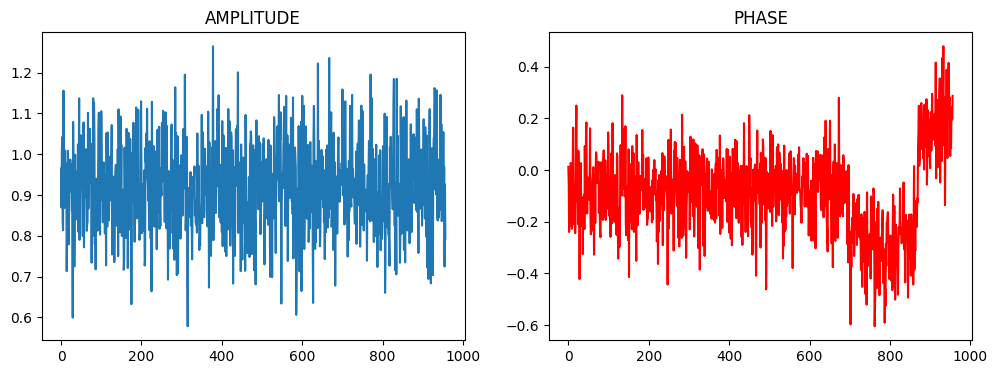

In [111]:
# Plot the XX pol model vis for one baseline for channel 0
to_plot = cal_test.VISIBILITY[:,0,0,0]
print(to_plot.baseline_id.compute())
plot_jones = GainJones.from_visibility(to_plot)

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].set_title('AMPLITUDE')
axs[0].plot(np.abs(plot_jones.matrix))
axs[1].set_title('PHASE')
axs[1].plot(np.angle(plot_jones.matrix), color='r')
plt.show()


In [112]:
# Setting up the vis equation
VE = VisEquation()
VE.setSolve(test_jones)
dir(test_jones)
test_jones.type
#print(test_jones.get_type)
# Set solve won't do much do much if we don't have any apply stages
# The set_solve re-orders the pre-apply steps to fit the current type into the correct location in the order

# Make VE using the set_solve assuming reordering in the future and make solve that calls Josh's solver? 
# Attempt scipy optimize for now?

Arranging VisEquation to solve for G GainJonesMatrix


{'name': 'G', 'value': 30}

In [113]:
# ==== JUST FOR TESTING SOLVER WITH scipy.optimize =====

def solveFunc(params, vis_obs, vis_model):
    ant1 = params[:4].reshape(2,2)
    ant2 = params[4:].reshape(2,2)
    vis_model = np.asarray(vis_model).reshape(2,2)
    vis_obs = vis_obs.reshape(2,2)
    #print(ant1, vis_model)
    res = np.dot(ant1, vis_model)
    res = np.dot(vis_model, np.conj(ant2))
    #print(((vis_obs - res).flatten()))
    return ((vis_obs - res).flatten())

# solve func should be gradient (should I just use chi2 for now...)

# for now we assume point-like source for model vis
# 1s with same shape as solve vis (make diagonal 0?)

# === UNUSED FOR NOW ===
model_vis = np.ones(np.shape(test_jones.matrix), dtype=complex)
# Make diag 0's
for i in range(len(model_vis)):
    model_vis[i][1] = 0+0j
    model_vis[i][2] = 0+0j
# ======================

# flatten vectors for the params to solve for
def to_vector(m1, m2):
    vec = np.hstack([m1.flatten(), m2.flatten()])
    return abs(vec)

# testing with vis dict? key value retrieval of obs_vis
def build_vis_dict(obs_vis):
    """
    returns the matrix that gives the observered vis value for each baseline
    ant1 x ant2 with each ant val being a 2x2 of the polarizations
    """
    ants = set(obs_vis.matrix.baseline_antenna1_name.values)
    ants = ants.union(set(obs_vis.matrix.baseline_antenna2_name.values))
    n_ant = len(ants)
    vis_dict = {}

    # for each baseline and the reverse assign the observed visibility
    for item in obs_vis.matrix:
        #print(item)
        _vis = item.values
        _ant1 = str(item.baseline_antenna1_name.values)
        _ant2 = str(item.baseline_antenna2_name.values)
        #print(_ant1, _ant2, _vis)
        
        if (_ant1, _ant2) not in vis_dict.keys():
            vis_dict[(_ant1, _ant2)] = _vis

        if (_ant2, _ant1) not in vis_dict.keys():
            vis_dict[(_ant2, _ant1)] = _vis

    return vis_dict
    
#print(build_vis_dict(test_jones))
    
# solver with scipy.optimize.least_squares
def solve(solve_vis, model_vis=(1+0j), starting_guess=[1+0j,0+0j,0+0j,1+0j]):
    # Currently just returning a dict of antenna gains
    # This can be changed to return an Xarray object
    solved_vals = {}
    vis_dict = build_vis_dict(solve_vis)
    tracking = {}

    ant_set = set(solve_vis.matrix.baseline_antenna1_name.values)
    ant_set = ant_set.union(set(solve_vis.matrix.baseline_antenna2_name.values))
    
    # For all ants in baselines init solution to starting guess
    for i in solve_vis.matrix:
        solved_vals.setdefault(str(i.baseline_antenna1_name.values), np.asarray(starting_guess))
        solved_vals.setdefault(str(i.baseline_antenna2_name.values), np.asarray(starting_guess))

        # Tracking for plots
        tracking.setdefault(str(i.baseline_antenna1_name.values), [np.asarray(starting_guess)])
        tracking.setdefault(str(i.baseline_antenna2_name.values), [np.asarray(starting_guess)])

    
    # all baseline pairs solved a dict instead of vis matrix
    # probably worse since we are doing a lot of looping but it lets us solve for all pols at once?
    for i in ant_set:
        for j in ant_set:
            if i == j: continue;

            ant1_gain = solved_vals[i]
            ant2_gain = solved_vals[j]
            ants = to_vector(ant1_gain, ant2_gain)

            res = least_squares(solveFunc, ants, args=(vis_dict[(i, j)], starting_guess))
            solved_vals[i] = res.x[:4]
            solved_vals[j] = res.x[4:]

            tracking[i].append(res.x[:4])
            tracking[j].append(res.x[4:])

            #print(res)
        

    print('---- after 1 iterations ----')
    for k,v in solved_vals.items():
        print(k, v)

    # ===== PLOTTING FOR FUN =====
    for k, v in tracking.items():
        #print(np.asarray(v)[:, :])
        p = [i[0] for i in v]
        plt.plot(p)
        break
        
    plt.show()
    # ==============================
    return solved_vals

#solved_vals = solve(test_jones, model_vis)

In [114]:
def generate_xr(solved_vals):
    xds = xr.Dataset(coords=solved_vals)
    #xds.assign_coords(solved_vals)

    return xds

#generate_xr(solved_vals)

2.929338930622195e-06


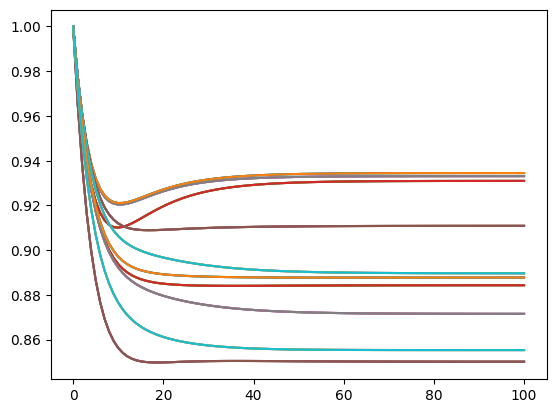

In [115]:
solved, tracked = VE.solve(plot=True)

In [116]:
'''toolviper.utils.data.download(file="Antennae_North.cal.lsrk.split.ms")

_ = convert_msv2_to_processing_set(
    in_file="Antennae_North.cal.lsrk.split.ms",
    out_file="Antennae_North.cal.lsrk.split.vis.zarr",
    parallel=False,
    overwrite=True,
    main_chunksize={
        "frequency": 3
    },
)'''
solved

<xarray.Dataset> Size: 640B
Dimensions:    (DA44_A120: 4, DA49_A127: 4, DA43_A115: 4, DA46_A129: 4,
                DA42_A123: 4, DA41_A110: 4, DA45_A091: 4, DA47_A074: 4,
                DA48_A070: 4, DA50_A108: 4)
Coordinates:
  * DA44_A120  (DA44_A120) complex128 64B (0.9100795914530112-0.0377952211552...
  * DA49_A127  (DA49_A127) complex128 64B (0.7502858327386065+0.3997294033390...
  * DA43_A115  (DA43_A115) complex128 64B (0.9051585864558586-0.2322171816286...
  * DA46_A129  (DA46_A129) complex128 64B (0.8809678934629682+0.0768122856737...
  * DA42_A123  (DA42_A123) complex128 64B (0.8996311464331926-0.2476440123293...
  * DA41_A110  (DA41_A110) complex128 64B (0.8662431972536689-0.3410512138047...
  * DA45_A091  (DA45_A091) complex128 64B (0.8862520261732744-0.0778279468957...
  * DA47_A074  (DA47_A074) complex128 64B (0.856944217230346+0.15872741381154...
  * DA48_A070  (DA48_A070) complex128 64B (0.8784588308622783+0.1280869135586...
  * DA50_A108  (DA50_A108) complex128 64B (0.8404524858228429+0.1587932160413...
Data variables:
    *empty*

0.949999988079071
0.9600000188704655
0.9699999754527201
0.9799999861897952
0.9900000133394176
1.000000030164656
1.0099999866009857
1.0200000168005363
1.0299999990634374
1.0400000395208722
--------------------------------------------------


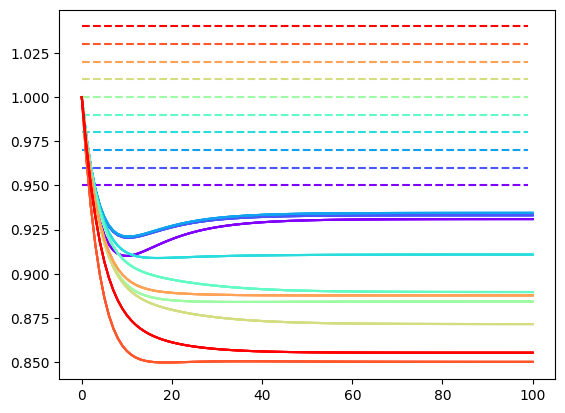

In [119]:
cal_data_path = "data/stored_cals.txt"
ref_cal = np.loadtxt(cal_data_path, dtype=complex)
# should be (2, 1, 40)
# 
#print(ref_cal.shape)
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, 10))

# for spw 0 print ant vals
# gains for one pol for 10 ant in spw 0
count = 0
for i in ref_cal[0,:10]:
    print(abs(i))
    plt.plot([abs(i)] * 100, linestyle='--', color=color[count])
    count += 1
    #break
print('-' * 50)
count = 0
for k, v in tracked.items():
    p = [abs(i) for i in v]
    plt.plot(p, color=color[count])
    count += 1
    #break
    
plt.show()

In [14]:
#test_vis.frequency.compute().values
cal_test
#[p for value in mxds.polarization.values for p in list(value)]

<xarray.MeasurementSetXds> Size: 20MB
Dimensions:                     (baseline_id: 45, time: 957, frequency: 8,
                                 polarization: 4, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    scan_number                 (time) int64 8kB dask.array<chunksize=(957,), meta=np.ndarray>
  * time                        (time) float64 8kB 1.503e+09 ... 1.503e+09
  * frequency                   (frequency) float64 64B 8.607e+10 ... 8.629e+10
  * polarization                (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 1MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 345kB dask.array<chunksize=(957, 45), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 1MB dask.array<chunksize=(957, 45, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 11MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 6MB dask.array<chunksize=(957, 45, 8, 4), meta=np.ndarray>
Attributes:
    creation_date:     2024-12-17T00:23:00.044895+00:00
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'flag': 'FL...
    observation_info:  {'observer': ['lknee'], 'project': 'uid://A002/X1f841f...
    partition_info:    {'field_name': ['J2255-3500_0'], 'intents': ['CALIBRAT...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9994
    type:              visibility
    xradio_version:    0.0.45
    antenna_xds:       <xarray.Dataset> Size: 2kB\nDimensions:               ...

In [15]:
ctable = CalibrationTable()
res = ctable.create_table(factory='gain').empty_like(dataset=cal_test)
#res["GAIN"][0,:,0,:]
pars = ['TIME',
 'FIELD_ID',
 'SPECTRAL_WINDOW_ID',
 'ANTENNA1',
 'ANTENNA2',
 'INTERVAL',
 'SCAN_NUMBER',
 'OBSERVATION_ID',
 'CPARAM',
 'PARAMERR',
 'FLAG',
 'SNR',
 'WEIGHT']
res
# using other data?
#ctable.create_table(factory='gain').empty_like(dataset=mxds)

[2025-02-06 11:41:48,993]     INFO    viperlog:  Module path: /Users/nschweig/RADPScal/calviper/src/calviper 


<xarray.Dataset> Size: 1MB
Dimensions:       (time: 957, antenna: 10, frequency: 8, polarization: 2,
                   gain: 1, scan_id: 957)
Coordinates:
  * time          (time) float64 8kB 1.503e+09 1.503e+09 ... 1.503e+09 1.503e+09
  * antenna       (antenna) <U9 360B 'DA41_A110' 'DA42_A123' ... 'DA50_A108'
  * frequency     (frequency) float64 64B 8.607e+10 8.61e+10 ... 8.629e+10
  * polarization  (polarization) <U1 8B 'X' 'Y'
  * scan_id       (scan_id) int64 8kB 2 2 2 2 2 2 2 2 ... 26 26 26 26 26 26 26
  * gain          (gain) float64 8B 1.0
Data variables:
    GAIN          (time, antenna, frequency, polarization, gain) float64 1MB ...
Attributes:
    calibration_type:  gain